In [1]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import pandas as pd
import os
import polars as pl
import toml
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick
from scipy import stats
import toml

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns

pio.renderers.default = "vscode"

In [2]:
_pth = toml.load("DATA_PATH.toml")["data_path"]["directory"]
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_00"

_base_pth = os.path.join(_pth, "recorded_data", _parent_folder)
_folder_list = os.listdir(_base_pth)[25:]


_webcam_calib_folder = os.path.join(
    _pth, "recorded_data", _parent_folder, _calib_folder_name
)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "spots_rotmat.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

MOCAP data

In [3]:
m1 = get_rb_marker_name(2)
m4 = get_rb_marker_name(3)
m3 = get_rb_marker_name(4)
m5 = get_rb_marker_name(5)

Getting Sync pulse from Teensy

In [162]:
_folder_name = _folder_list[5]
_teensy_df = pl.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_teensy_df = _teensy_df.with_columns(
    pl.col("mz\r").str.replace("\r", "").cast(pl.Float64).alias("mz")
)
t_time = _teensy_df["rust_time"].to_numpy()
t_time = [datetime.fromtimestamp(t) for t in t_time]
# t_time = [datetime.strftime(t) for t in t_time]
teensy_df = pl.DataFrame({"time": t_time, "sync": _teensy_df["sync"]})

for idx, i in enumerate(teensy_df["sync"]):
    if i == 1:
        break
teensy_start_time = teensy_df["time"][idx]

In [163]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = int(_folder_name.split("_")[2]) / 100
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [164]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [165]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [166]:
_video_pth = os.path.join(_base_pth, _folder_name, "webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}

counter = 0

for _frame in tqdm(_video_data):
    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedpoints = detector.detectMarkers(_frame)
    # refine corners
    corners, ids, rejectedpoints, _ = detector.refineDetectedMarkers(
        image=_frame,
        board=board,
        detectedCorners=corners,
        detectedIds=ids,
        rejectedCorners=rejectedpoints,
        cameraMatrix=_webcam_cam_mat,
        distCoeffs=_webcam_dist,
    )
    rvec, tvec = estimatePoseSingleMarkers(
        corners=corners,
        marker_size=markerLength,
        mtx=_webcam_cam_mat,
        distortion=_webcam_dist,
    )

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)

    counter += 1


_video_file.close()

101it [00:01, 65.10it/s]


In [167]:
coordinate = {
    str(default_ids[0]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[1]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[2]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
}

doesnt_exist = []
# default_ids = [100, 49, 80]
zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        _zero_counter = 0
        for j, _m in enumerate(data["marker_ids"][i]):
            if _m in default_ids:
                coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)

    doesnt_exist.clear()

AR coordinate transformation

In [168]:
if type(ts[0]) != datetime:
    # convert epoch to datetime
    ts = [datetime.fromtimestamp(t) for t in ts]
translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

ar_df = pl.DataFrame(
    {
        "time": ts,
        "x": coordinate[str(default_ids[2])]["x"][: len(ts)],
        "y": coordinate[str(default_ids[2])]["y"][: len(ts)],
        "z": coordinate[str(default_ids[2])]["z"][: len(ts)],
        "rx": coordinate[str(default_ids[2])]["rx"][: len(ts)],
        "ry": coordinate[str(default_ids[2])]["ry"][: len(ts)],
        "rz": coordinate[str(default_ids[2])]["rz"][: len(ts)],
    }
)
tar = _ar_lframe_rot.T @ (
    np.array(ar_df[["x", "y", "z"]].to_numpy()).T - (_ar_lframe_org)
)
_ar_df = pl.DataFrame(
    {
        "time": ts,
        "x": tar[0],
        "y": tar[1],
        "z": tar[2],
        "rx": coordinate[str(default_ids[2])]["rx"][: len(ts)],
        "ry": coordinate[str(default_ids[2])]["ry"][: len(ts)],
        "rz": coordinate[str(default_ids[2])]["rz"][: len(ts)],
    }
)

Reading mocap data

In [169]:
_mocap_pth = os.path.join(
    os.path.dirname(os.path.dirname(_video_pth)),
    _folder_name.split("_")[0],
    f"{_folder_name}.csv",
)
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df = pl.from_pandas(_mocap_df)

cumulative = (
    _mocap_df[[m1["x"], m1["y"], m1["z"]]].to_numpy().T
    + _mocap_df[[m4["x"], m4["y"], m4["z"]]].to_numpy().T
    + _mocap_df[[m3["x"], m3["y"], m3["z"]]].to_numpy().T
    + _mocap_df[[m5["x"], m5["y"], m5["z"]]].to_numpy().T
)
cumulative = cumulative / 4

_m_df = pl.DataFrame(
    {
        "time": _mocap_df["time"],
        "x": cumulative[0],
        "y": cumulative[1],
        "z": cumulative[2],
    }
)

In [170]:
_offset = (_ar_df[["x", "y", "z"]][0] - _m_df[["x", "y", "z"]][0]).to_numpy()[0]

In [171]:
_offset

array([ 0.02367784, -0.04401672,  0.02223702])

In [172]:
_ar_df = _ar_df.with_columns(
    [
        (pl.col("x") - _offset[0]).alias("x"),
        (pl.col("y") - _offset[1]).alias("y"),
        (pl.col("z") - _offset[2]).alias("z"),
    ]
)

MoCap transformation

Correct time offset in AR

In [173]:
_time_offset = teensy_df["time"][idx] - ar_df["time"][0]

# interpolate teensy data to match aruco data

_temp_df = _ar_df.to_pandas()
clip_idx = _temp_df["time"].sub(teensy_df["time"][idx]).abs().idxmin()

_ar_df_test = _ar_df[clip_idx:]

_data_time_offset = _ar_df_test["time"][0] - _mocap_df["time"][0]
_ar_df_test = _ar_df_test.with_columns(
    [(pl.col("time") - _data_time_offset).alias("time")]
)
_ar_df = _ar_df_test

In [174]:
ar_time = _ar_df["time"].dt.epoch()
ar_time = ar_time - ar_time[0]
ar_time = [timedelta(microseconds=t).total_seconds() for t in ar_time]
ar_time = np.array(ar_time)

mc_time = _mocap_df["time"].dt.epoch()
mc_time = mc_time - mc_time[0]
mc_time = [timedelta(microseconds=t).total_seconds() for t in mc_time]
mc_time = np.array(mc_time)

ar_del_t = _ar_df["time"].diff().mean() / 10**6
mc_del_t = 0.01

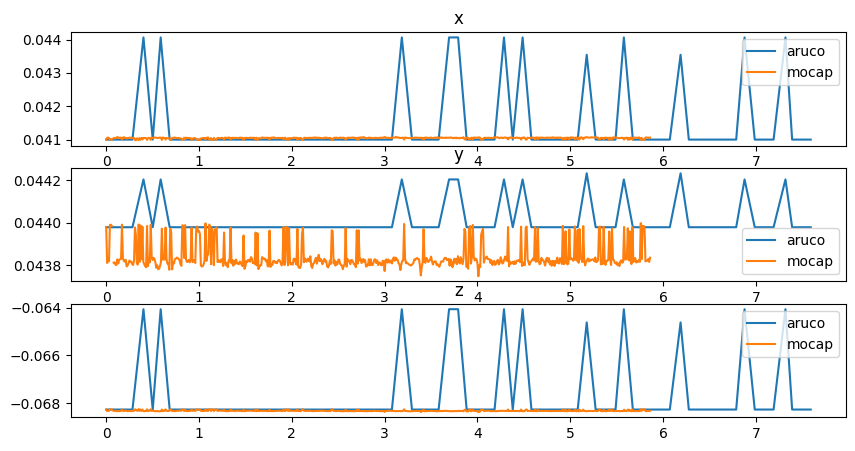

In [175]:
# subplots 3 rows 1 column
fig, axs = plt.subplots(3, 1, figsize=(10, 5))

# plot x
axs[0].plot(ar_time, _ar_df["x"], label="aruco")
axs[0].plot(mc_time, _m_df["x"], label="mocap")
axs[0].set_title("x")
axs[0].legend()

# plot y
axs[1].plot(ar_time, _ar_df["y"], label="aruco")
axs[1].plot(mc_time, _m_df["y"], label="mocap")
axs[1].set_title("y")
axs[1].legend()

# plot z
axs[2].plot(ar_time, _ar_df["z"], label="aruco")
axs[2].plot(mc_time, _m_df["z"], label="mocap")
axs[2].set_title("z")
axs[2].legend()

Interpolating dfs

In [189]:
_new_mc = {"time": _ar_df["time"], "x": [], "y": [], "z": []}

for i in ["x", "y", "z"]:
    f = interp1d(
        _m_df["time"].dt.epoch(), _m_df[i], kind="linear", fill_value="extrapolate"
    )
    _mc_val = f(_ar_df["time"].dt.epoch())
    _new_mc[i] = _mc_val

_mc_df = pl.DataFrame(_new_mc)

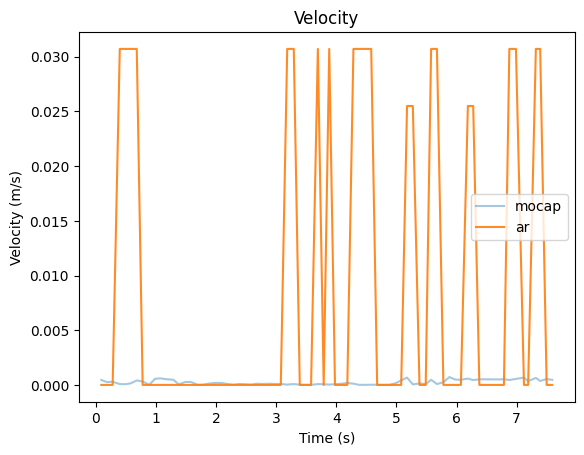

In [188]:
plt.plot(
    ar_time, abs(_mc_df["x"][: len(_mc_df)].diff()) / ar_del_t, label="mocap", alpha=0.4
)
plt.plot(ar_time, abs(_ar_df["x"].diff()) / ar_del_t, alpha=0.9, label="ar")
plt.title("Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()